# **Required Libraries** 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pathlib
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import tensorflow as tf
import random
import pickle
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# **Hyperparameter Configuration**

In [2]:
# setting image parameters
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_COLOR_CHANNELS = 3  # RGB

# encoding labels
labels_dict = {
  'negative': 0,
  'positive': 1,
}

# **Required Services**

In [3]:
# getting positive index from .csv files 
def get_positive_index(x):
    if "," in x:
        start = x.split(" , ")
        index_1 = list(np.arange(int(start[0].split(" to ")[0]),int(start[0].split(" to ")[1])+1))
        index_2 = list(np.arange(int(start[1].split(" to ")[0]),int(start[1].split(" to ")[1])+1))
        return index_1 + index_2
    else:
        return list(np.arange(int(x.split(" to ")[0]),int(x.split(" to ")[1])+1))

# getting negative index from .csv files     
def get_negative_index(count,positive_index_val):
    total_range = list(np.arange(1,count+1))
    index = [i for i in total_range if i not in list(positive_index_val)]
    return index

# Image preprocessing function
def get_image_array(positive_images,negative_images,IMAGE_WIDTH=128,IMAGE_HEIGHT=128):
  """
  This function resizes the images
  and converts it to an numpy array and
  returns it along with the class labels
  """
  images_dict = {
    'positive': positive_images,
    'negative': negative_images,
  }
  X, y = [], []

  for image_type, images in images_dict.items():
    for image in images:
      img = cv2.imread(str(image))
      if isinstance(img,type(None)): 
        pass
          
      elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
        resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
        X.append(resized_img)
        y.append(labels_dict[image_type])
      else:
        pass
  X = np.array(X)
  y = np.array(y)

  return X,y

# Define a custom F1-score function
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

## Segregating the images
 - We have converted the DICOM files into JPG images manually using the tool "Radiantviewer".
 - Using the below code we have seggregated the converted images in "Positive" and "Negative" folders as per the labels provided in the "Stroke _DCM _Train_Labels.xlsx" file.

In [4]:
excel_file = 'Stroke _DCM _Train_Labels.xlsx'
stk_labels = pd.read_excel(excel_file,header=[1],nrows=108)


stk_labels["positive_index"] = stk_labels["Positive"].apply(lambda x: get_positive_index(x))
stk_labels["negative_index"] = stk_labels[["Unnamed: 2","positive_index"]].apply(lambda x: get_negative_index(x["Unnamed: 2"],x["positive_index"]),axis=1)

# rename the columns
stk_labels.rename(columns = {'Unnamed: 0': "Count", "Unnamed: 1": "IMAGE NAME", "Unnamed: 2": "IMAGE COUNT"}, inplace = True)

stk_labels

,Count,IMAGE NAME,IMAGE COUNT,Positive,Total Positive,Negative,positive_index,negative_index
0,1,STP21,50,26 to 44,19,31,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,STP22,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,3,STP23,50,26 to 42,17,33,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,4,STP24,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,5,STP25,50,26 to 45,20,30,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...,...,...,...
103,104,STP126,50,26 to 43,18,32,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
104,105,STP128,50,26 to 43,18,32,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
105,106,STP129,50,26 to 44,19,31,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
106,107,STP130,48,25 to 48,24,24,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


## Data Quality Check

In [5]:
# QC
stk_labels["postive_count_QC"] = stk_labels["positive_index"].apply(lambda x: len(x))
stk_labels["negative_count_QC"] = stk_labels["negative_index"].apply(lambda x: len(x))
stk_labels

,Count,IMAGE NAME,IMAGE COUNT,Positive,Total Positive,Negative,positive_index,negative_index,postive_count_QC,negative_count_QC
0,1,STP21,50,26 to 44,19,31,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19,31
1,2,STP22,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",21,29
2,3,STP23,50,26 to 42,17,33,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",17,33
3,4,STP24,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",21,29
4,5,STP25,50,26 to 45,20,30,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",20,30
...,...,...,...,...,...,...,...,...,...,...
103,104,STP126,50,26 to 43,18,32,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,32
104,105,STP128,50,26 to 43,18,32,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,32
105,106,STP129,50,26 to 44,19,31,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19,31
106,107,STP130,48,25 to 48,24,24,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24,24


parent_folder = 'Train stroke JPG'
already contains images patientwise

two new folders added positive & negative in same directory

In [6]:
# Seggregating stroke_yes images in positive folder and stroke_no images in negative folder

parent_folder = 'Train stroke JPG'

# Create the destination folders
pos_folder = os.path.join(parent_folder, 'positive')
neg_folder = os.path.join(parent_folder, 'negative')
os.makedirs(pos_folder, exist_ok=True)
os.makedirs(neg_folder, exist_ok=True)

# Iterate through subfolders
for subfolder in tqdm(os.listdir(parent_folder)):
    subfolder_path = os.path.join(parent_folder, subfolder)
    subfolder_path = os.path.join(subfolder_path, "STUDY")
    if os.path.isdir(subfolder_path) and subfolder not in ['positive', 'negative']:
        
        # Iterate through files in the subfolder
        files = [f for f in os.listdir(subfolder_path) if f.lower().endswith('.jpg')]
        files.sort()
        
        pos_list = stk_labels[stk_labels["IMAGE NAME"]==subfolder]["positive_index"].values[0]
        neg_list = stk_labels[stk_labels["IMAGE NAME"]==subfolder]["negative_index"].values[0]
        
        # Now, the files list is sorted in the sequence of the images
        for index, file in enumerate(files, start=1):
            file_path = os.path.join(subfolder_path, file)
            
            if index in pos_list:
                dest_path = os.path.join(pos_folder, subfolder+"_"+file)
                shutil.move(file_path, dest_path)
                
            elif index in neg_list:
                dest_path = os.path.join(neg_folder, subfolder+"_"+file)
                shutil.move(file_path, dest_path)

100%|███████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 605.26it/s]


# **Data Analysis**


*   Analysing data weather it is balanced or not
*   Analysing frequency of positive index



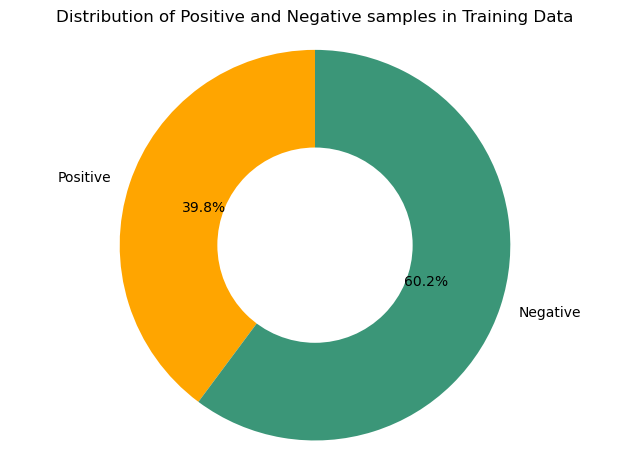

In [7]:
# Pie chart data
sizes = [stk_labels["postive_count_QC"].sum(), stk_labels["negative_count_QC"].sum()]
labels = ['Positive', 'Negative']
colors = ['orange','#3b9678']

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Draw white circle in the center
center_circle = plt.Circle((0, 0), 0.5, fc='white')
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Distribution of Positive and Negative samples in Training Data')
plt.tight_layout()
plt.show()


**Positives** are **39.8%** and **Negatives** are **60.2%** in the training data.
Data is slighlty **imbalanced**.

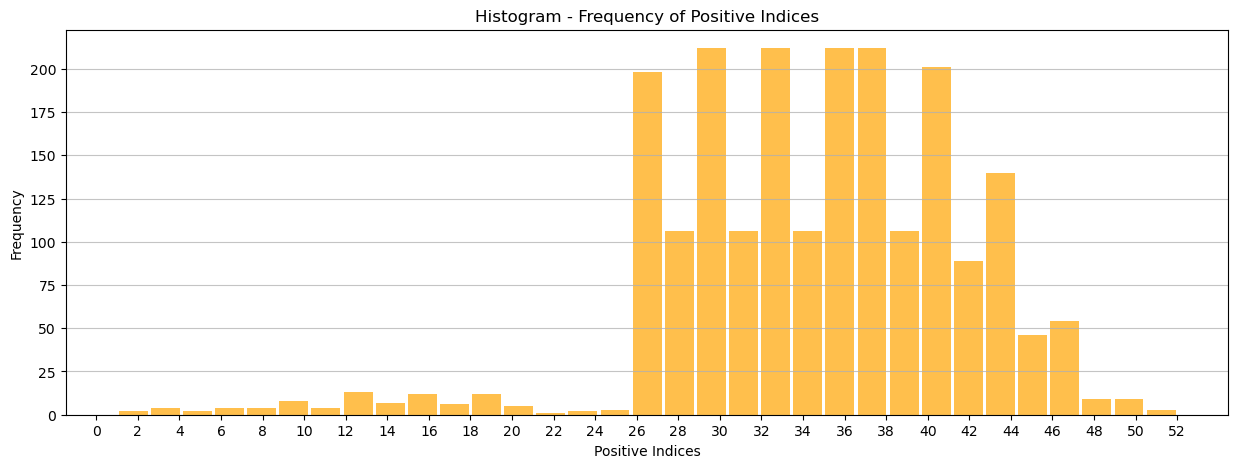

In [8]:
# Extract positive index data
positive_indices = stk_labels["positive_index"].explode()

# Create histogram
fig = plt.figure(figsize=(15,5))
plt.hist(positive_indices, bins='auto', color='orange', alpha=0.7, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Positive Indices')
plt.ylabel('Frequency')
plt.title('Histogram - Frequency of Positive Indices')

# Decrease step size on x-axis
min_value = 0
max_value = int(np.max(positive_indices))
step_size = 2  # Adjust this value to change the step size
plt.xticks(np.arange(min_value, max_value+1, step_size))

plt.show()


From the above histogram it could be inferred that the frequency of positives are very high between 26 to 44.

## Load Image Data Positive stroke & Negative Stroke separately.

In [9]:
data_dir = pathlib.Path('Train stroke JPG')

# training data
train_positive_images = list(data_dir.glob('positive/*.jpg'))
train_negative_images = list(data_dir.glob('negative/*.jpg'))

print(f"Total # of Positive images: {len(train_positive_images)}\nTotal # of Negative images: {len(train_negative_images)}")



Total # of Positive images: 2110
Total # of Negative images: 3190


In [10]:
len(train_negative_images) + len(train_positive_images)

5300

## **Image Resizing & Train-Validation Split**


*   Splitting the datset into train & validation using 80-20 split




In [11]:
X, y = get_image_array(train_positive_images,train_negative_images,IMAGE_WIDTH,IMAGE_HEIGHT)

# train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train array shape: {X_train.shape}")
print(f"Test array shape: {X_val.shape}")

Train array shape: (4240, 170, 170, 3)
Test array shape: (1060, 170, 170, 3)


## **Model**

In [12]:
# CNN model
model = keras.models.Sequential(
  [
    # input layer
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_COLOR_CHANNELS)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # hidden layer 1
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # hidden layer 2
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # output layer
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
  ]
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=f1_score)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 168, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 168, 168, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 84, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 84, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 82, 82, 64)       2

### **Training the Model**

In [13]:
result = []
for i in range(2):
    print(f"Iteration {i}")
    result.append(model.fit(X_train, y_train, epochs=15))


Iteration 0
Epoch 1/15
133/133 [==============================] - 50s 276ms/step - loss: 0.4790 - f1_score: 0.7359
Epoch 2/15
133/133 [==============================] - 36s 271ms/step - loss: 0.2912 - f1_score: 0.8641
Epoch 3/15
133/133 [==============================] - 36s 270ms/step - loss: 0.2544 - f1_score: 0.8727
Epoch 4/15
133/133 [==============================] - 36s 270ms/step - loss: 0.2293 - f1_score: 0.8891
Epoch 5/15
133/133 [==============================] - 36s 270ms/step - loss: 0.2041 - f1_score: 0.9020
Epoch 6/15
133/133 [==============================] - 36s 270ms/step - loss: 0.2102 - f1_score: 0.8938
Epoch 7/15
133/133 [==============================] - 36s 270ms/step - loss: 0.1901 - f1_score: 0.9037
Epoch 8/15
133/133 [==============================] - 36s 269ms/step - loss: 0.1949 - f1_score: 0.9043
Epoch 9/15
133/133 [==============================] - 36s 269ms/step - loss: 0.1810 - f1_score: 0.9060
Epoch 10/15
133/133 [==============================] - 36s 26

In [14]:
#save the model
model.save('Brain Stroke Model/strokeModel.h5')

# save the array using pickle
with open('Brain Stroke Model/result_array.pkl', 'wb') as f:
    pickle.dump(result, f)

INFO:tensorflow:Assets written to: ram://f946988e-50a6-462c-8a3a-0a88599b5a80/assets


INFO:tensorflow:Assets written to: ram://f946988e-50a6-462c-8a3a-0a88599b5a80/assets


### **Model Evaluation**

In [15]:

# # Register the custom object
# tf.keras.utils.get_custom_objects().update({'f1_score': f1_score})

# # Load the model
# model = tf.keras.models.load_model('/content/drive/MyDrive/Brain Stroke Model/strokeModel.h5', compile=True)


# # load the array using pickle
# with open('/content/drive/MyDrive/Brain Stroke Model/result_array.pkl', 'rb') as f:
#     loaded_arr = pickle.load(f)

# # print the loaded array
# print(loaded_arr)

In [16]:
train_loss,train_f1 = model.evaluate(X_train,y_train,verbose=0)
val_loss,val_f1 = model.evaluate(X_val,y_val,verbose=0)

print(f"Training Loss: {round(100*train_loss,2)}% , Training f1-score: {round(train_f1,2)}")
print(f"Validaton Loss: {round(100*val_loss,2)}% , Validaton f1-score: {round(val_f1,2)}")

# getting test predictions
y_pred = model.predict(X_val,verbose=0)

cuttoff = 0.5 # setting a cutt-off value for the prediction class
y_pred_classes = [0 if value < cuttoff else 1 for value in y_pred]

# generating the classification report
print("Classification Report:")
display(pd.DataFrame(classification_report(y_val, y_pred_classes,output_dict=True)).T)

Training Loss: 32.7% , Training f1-score: 0.96
Validaton Loss: 56.8% , Validaton f1-score: 0.92
Classification Report:


,precision,recall,f1-score,support
0,0.959283,0.927559,0.943155,635.000000
1,0.896861,0.941176,0.918485,425.000000
accuracy,0.933019,0.933019,0.933019,0.933019
macro avg,0.928072,0.934368,0.930820,1060.000000
weighted avg,0.934256,0.933019,0.933263,1060.000000


Confusion Matrix:


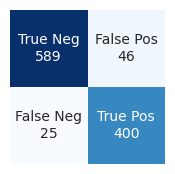

In [17]:
# generating the confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred_classes)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig = plt.figure(figsize=(2,2))
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues',cbar=False,xticklabels=False, yticklabels=False)
print("Confusion Matrix:")
plt.show()

F1-score & Loss vs. Epoch


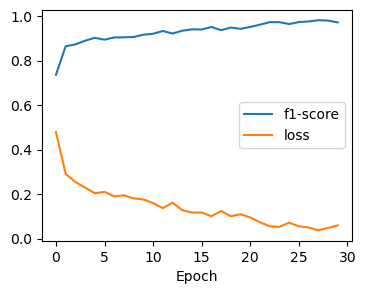

In [18]:
# plotting loss & f1-score vs. epoch
f1_scores = result[0].history['f1_score'] + result[1].history['f1_score']
loss = result[0].history['loss'] + result[1].history['loss']

fig = plt.figure(figsize=(4,3))
plt.plot(f1_scores, label='f1-score')  
plt.plot(loss, label='loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
print("F1-score & Loss vs. Epoch")
plt.show()

# **Test Data Prediction**

In [25]:
# loading the test data
test_data_dir = pathlib.Path("Test_V1/Test_V1")

test_images = list(test_data_dir.glob('*.jpg'))

print("Total number of test data: ",len(test_images))

Total number of test data:  175


## Test Image Quality Check

Resizes each image to the dimensions specified by IMAGE_WIDTH and IMAGE_HEIGHT, and stores them in the list X_test. It also extracts the file names of the images (without the ".jpg" extension) and stores them in the list file_name. Finally, it converts the list X_test to a NumPy array for further processing. The code also checks if the image is NoneType or if it's height and width are smaller than the specified dimensions, and skips those images.

In [26]:
X_test = []
file_name = []

for image in test_images:
      img = cv2.imread(str(image))
      if isinstance(img,type(None)): 
        pass
          
      elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
        resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
        X_test.append(resized_img)
        file_name.append(str(image).split("/")[-1].replace(".jpg",""))
      else:
        pass
    
X_test = np.array(X_test)

In [27]:
# getting test predictions
y_pred_test = model.predict(X_test,verbose=0)

cuttoff = 0.5 # setting a cutt-off value for the prediction class
y_pred_test_classes = [0 if value < cuttoff else 1 for value in y_pred_test]

# checking the ratio of the classes in test data
pd.Series(y_pred_test_classes).value_counts(normalize=True)

1    0.571429
0    0.428571
dtype: float64

In [30]:
# exporting the test predictions
sample_submission_df = pd.concat([pd.Series(file_name),pd.Series(y_pred_test_classes)],axis=1).rename(columns={0:"SN",1:"Label"})
sample_submission_df["SN"] = sample_submission_df["SN"].astype("int")
sample_submission_df.sort_values(by=["SN"],inplace=True)
sample_submission_df.reset_index(drop=True,inplace=True)

ValueError: invalid literal for int() with base 10: 'Test_V1\\Test_V1\\1'

In [31]:
sample_submission_df.head(50)

,SN,Label
0,Test_V1\Test_V1\1,1
1,Test_V1\Test_V1\10,1
2,Test_V1\Test_V1\100,1
3,Test_V1\Test_V1\11,1
4,Test_V1\Test_V1\12,1
5,Test_V1\Test_V1\13,1
6,Test_V1\Test_V1\14,1
7,Test_V1\Test_V1\15,1
8,Test_V1\Test_V1\16,0
9,Test_V1\Test_V1\17,0


In [ ]:
sample_submission_df.to_csv("Brain Stroke Model/sample_test_label_brain_stroke_v3_final.csv",index=False)


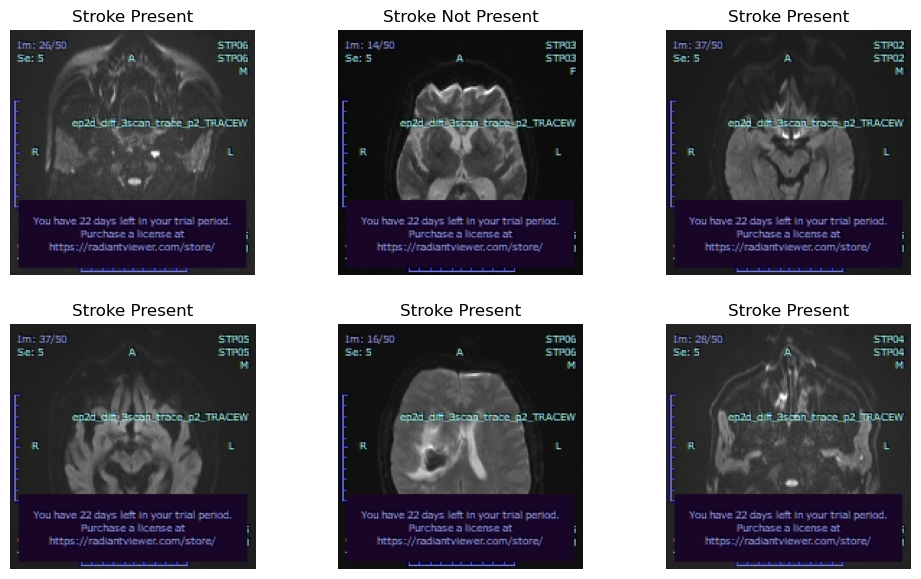

In [33]:
random_indexes = random.sample(range(len(X_test)), k=6)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for (idx, c_ax) in zip(random_indexes, axs.flatten()):
    c_ax.imshow(X_test[idx], cmap="gray")
    if y_pred_test_classes[idx] == 1:
        title = "Stroke Present"
    else:
        title = "Stroke Not Present" 
    c_ax.set_title(title)
    c_ax.axis("off")